### Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

### Loading modules and libraries

In [78]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy import special 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import math
from IPython.display import Markdown, display ,HTML


from sklearn.model_selection import train_test_split


#### Reading Data and Data Preparation

In [79]:
telecom_df= pd.read_csv('telecom_churn_data.csv')
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [80]:
telecom_df.shape

(99999, 226)

In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase [Month 6 & 7]
The ‘action’ phase [Month 8]
The ‘churn’ phase [Month 9]
In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

In [81]:
#Find columns with recharge info
#since total recharge amount is to be used for High Value Customer Filter
df_recharge_col = [col for col in telecom_df.columns if 'total_rech_' in col]
print(df_recharge_col)

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']


In [82]:
telecom_df[df_recharge_col].head()

,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9
0,4,3,2,6,362,252,252,0,1.0,1.0,1.0,NaN
1,4,9,11,5,74,384,283,121,NaN,1.0,2.0,NaN
2,5,4,2,7,168,315,116,358,NaN,NaN,NaN,1.0
3,10,11,18,14,230,310,601,410,NaN,NaN,NaN,NaN
4,5,6,3,4,196,350,287,200,1.0,NaN,NaN,NaN


In [83]:
df_avg_recharge_col = [col for col in telecom_df.columns if 'av_rech' in col]
print(df_avg_recharge_col)
telecom_df[df_avg_recharge_col].head()

['av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
0,252.0,252.0,252.0,NaN
1,NaN,154.0,50.0,NaN
2,NaN,NaN,NaN,46.0
3,NaN,NaN,NaN,NaN
4,56.0,NaN,NaN,NaN


In [84]:
#Derive Total Data Recharge Amounts = total recharge* avg_recharge

telecom_df["total_recharge_data_amt_6"] = telecom_df["total_rech_data_6"]  * telecom_df['av_rech_amt_data_6']
telecom_df["total_recharge_data_amt_7"] = telecom_df["total_rech_data_7"]  * telecom_df['av_rech_amt_data_7']
telecom_df["total_recharge_data_amt_8"] = telecom_df["total_rech_data_8"]  * telecom_df['av_rech_amt_data_8']
telecom_df["total_recharge_data_amt_9"] = telecom_df["total_rech_data_9"]  * telecom_df['av_rech_amt_data_9']

In [85]:
df_total_recharge_data = [col for col in telecom_df.columns if 'total_rech_data' in col]
print(df_total_recharge_data)

['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']


In [86]:
drop_col = df_total_recharge_data+df_avg_recharge_col
print(drop_col)
telecom_df.drop(drop_col, axis=1, inplace=True)

['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [87]:
#Average of Recharge Amount in 6th and 7th Month
avg_recharge_amt_6n7 = (telecom_df["total_rech_amt_6"].fillna(0) + telecom_df["total_recharge_data_amt_6"].fillna(0) + 
telecom_df["total_rech_amt_7"].fillna(0) + telecom_df["total_recharge_data_amt_7"].fillna(0))/2.0

#70th Percentile of Avg Recharge Amount
percentile70_6n7 = np.percentile(avg_recharge_amt_6n7, 70.0)
print('70 percentile of 6th and 7th months avg recharge amount: ', percentile70_6n7)

new_telecom_df = telecom_df[avg_recharge_amt_6n7 >= percentile70_6n7]
print('Dataframe Shape after Filtering HIgh Value Customers: ', new_telecom_df.shape)

70 percentile of 6th and 7th months avg recharge amount:  478.0
Dataframe Shape after Filtering HIgh Value Customers:  (30001, 222)


In [88]:
#Rename Columns with Meaning full Names
# aug_vbc_3g jul_vbc_3g jun_vbc_3g sep_vbc_3g

new_telecom_df.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 
                                 'jul_vbc_3g': 'vbc_3g_7', 
                                 'aug_vbc_3g': 'vbc_3g_8', 
                                 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

### Tag churners

In [89]:
month_9_data = [col for col in new_telecom_df.columns if '_9' in col]
new_telecom_df[month_9_data].head()



,last_date_of_month_9,arpu_9,onnet_mou_9,offnet_mou_9,roam_ic_mou_9,roam_og_mou_9,loc_og_t2t_mou_9,loc_og_t2m_mou_9,loc_og_t2f_mou_9,loc_og_t2c_mou_9,...,arpu_3g_9,arpu_2g_9,night_pck_user_9,monthly_2g_9,sachet_2g_9,monthly_3g_9,sachet_3g_9,fb_user_9,vbc_3g_9,total_recharge_data_amt_9
0,9/30/2014,21.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,NaN,3.58,NaN
7,9/30/2014,500.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN
8,9/30/2014,166.787,33.46,108.71,0.0,0.0,26.13,34.58,0.00,0.00,...,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN
21,9/30/2014,578.596,161.63,869.89,0.0,0.0,29.98,107.54,0.00,0.00,...,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN
23,9/30/2014,811.480,15.74,111.88,0.0,0.0,15.74,83.73,2.45,4.08,...,212.17,212.17,0.0,0,0,1,0,1.0,0.00,252.0


#### Realising that columns total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9' will be enough to tag the customer as churn or not

In [90]:
new_telecom_df['churn'] = np.where(new_telecom_df[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 
                                   1,
                                   0)

In [91]:
# droping all columns related with 9th month data
new_telecom_df.drop(month_9_data, axis=1, inplace=True)
new_telecom_df.shape

(30001, 169)

In [92]:
new_telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_recharge_data_amt_6,total_recharge_data_amt_7,total_recharge_data_amt_8,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,...,1.0,1.0,968,30.40,0.00,101.20,252.0,252.0,252.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,...,NaN,NaN,802,57.74,19.38,18.74,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,...,1.0,1.0,315,21.03,910.65,122.16,NaN,354.0,207.0,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,514.453,597.753,...,NaN,NaN,720,0.00,0.00,0.00,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,74.350,193.897,...,1.0,1.0,604,40.45,51.86,0.00,NaN,712.0,540.0,0


### Data Cleaning and Exploratory data analysis.

In [93]:
#Checking the object data type coulmns in the dataframe
new_telecom_df.select_dtypes(include=['object']).iloc[0]

last_date_of_month_6        6/30/2014
last_date_of_month_7        7/31/2014
last_date_of_month_8        8/31/2014
date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_data_6    6/21/2014
date_of_last_rech_data_7    7/16/2014
date_of_last_rech_data_8     8/8/2014
Name: 0, dtype: object

In [94]:
# convert to datetime
for col in new_telecom_df.select_dtypes(include=['object']).columns:
    new_telecom_df[col] = pd.to_datetime(new_telecom_df[col])

new_telecom_df.shape

(30001, 169)

In [95]:
#Since for all these columns month and year remains same, we can only take date
new_telecom_df.date_of_last_rech_6 = new_telecom_df.date_of_last_rech_6.dt.day
new_telecom_df.date_of_last_rech_7 = new_telecom_df.date_of_last_rech_7.dt.day
new_telecom_df.date_of_last_rech_8 = new_telecom_df.date_of_last_rech_8.dt.day
new_telecom_df.date_of_last_rech_data_6 = new_telecom_df.date_of_last_rech_data_6.dt.day
new_telecom_df.date_of_last_rech_data_7 = new_telecom_df.date_of_last_rech_data_7.dt.day
new_telecom_df.date_of_last_rech_data_8 = new_telecom_df.date_of_last_rech_data_8.dt.day
new_telecom_df.last_date_of_month_6 = new_telecom_df.last_date_of_month_6.dt.day
new_telecom_df.last_date_of_month_7 = new_telecom_df.last_date_of_month_7.dt.day
new_telecom_df.last_date_of_month_8 = new_telecom_df.last_date_of_month_8.dt.day

In [96]:
new_telecom_df.date_of_last_rech_6

0        21.0
7        27.0
8        25.0
21       30.0
23       18.0
         ... 
99981    17.0
99984    21.0
99986    20.0
99988    30.0
99997    17.0
Name: date_of_last_rech_6, Length: 30001, dtype: float64

In [97]:
#We can now calculate days since last recharge by subtracting last date of month from date columns
new_telecom_df['days_since_last_rech_6'] = new_telecom_df.last_date_of_month_6 - new_telecom_df.date_of_last_rech_6
new_telecom_df['days_since_last_rech_7'] = new_telecom_df.last_date_of_month_7 - new_telecom_df.date_of_last_rech_7
new_telecom_df['days_since_last_rech_8'] = new_telecom_df.last_date_of_month_8 - new_telecom_df.date_of_last_rech_8
new_telecom_df['days_since_last_rech_data_6'] = new_telecom_df.last_date_of_month_6 - new_telecom_df.date_of_last_rech_data_6
new_telecom_df['days_since_last_rech_data_7'] = new_telecom_df.last_date_of_month_7 - new_telecom_df.date_of_last_rech_data_7
new_telecom_df['days_since_last_rech_data_8'] = new_telecom_df.last_date_of_month_8 - new_telecom_df.date_of_last_rech_data_8
new_telecom_df.shape

(30001, 175)

In [98]:
new_telecom_df.days_since_last_rech_6

0         9.0
7         3.0
8         5.0
21        0.0
23       12.0
         ... 
99981    13.0
99984     9.0
99986    10.0
99988     0.0
99997    13.0
Name: days_since_last_rech_6, Length: 30001, dtype: float64

In [99]:
# we can now drop all 9 date columns and keeps days_since only
print("Shape Before dropping date columns",new_telecom_df.shape)
new_telecom_df = new_telecom_df.loc[:,~new_telecom_df.columns.str.contains('date')]
print("Shape After dropping date columns",new_telecom_df.shape)

Shape Before dropping date columns (30001, 175)
Shape After dropping date columns (30001, 166)


In [100]:
#Remove Data which has only 1 Value, it is practically no use for models.

new_telecom_df.loc[:,new_telecom_df.apply(pd.Series.nunique) == 1].head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
0,109,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0
7,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
#Remove single value Columns 
new_telecom_df = new_telecom_df.loc[:,new_telecom_df.apply(pd.Series.nunique) != 1]
new_telecom_df.shape

(30001, 156)

In [102]:
#Columns with > 45% of missing values and not for 9th Month
columns = new_telecom_df.columns
missing_value = new_telecom_df.isnull().sum() * 100 / len(new_telecom_df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'missing_value': missing_value})
missing_value_df[missing_value >= 45].head(100)



,column_name,missing_value
max_rech_data_8,max_rech_data_8,46.825106
count_rech_2g_8,count_rech_2g_8,46.825106
count_rech_3g_8,count_rech_3g_8,46.825106
arpu_3g_8,arpu_3g_8,46.825106
arpu_2g_8,arpu_2g_8,46.825106
night_pck_user_8,night_pck_user_8,46.825106
fb_user_8,fb_user_8,46.825106
total_recharge_data_amt_8,total_recharge_data_amt_8,46.825106
days_since_last_rech_data_8,days_since_last_rech_data_8,46.825106


In [103]:
#As it can be seem these are the users who have only used calling services and no data service in 8th month
#Therefore can be imputed with 0
new_telecom_df.loc[new_telecom_df.max_rech_data_8.isnull(),new_telecom_df.columns.str.contains('_8')]

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,night_pck_user_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_8,vbc_3g_8,total_recharge_data_amt_8,days_since_last_rech_8,days_since_last_rech_data_8
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,...,NaN,0,0,0,0,NaN,57.74,NaN,5.0,NaN
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,...,NaN,0,0,0,0,NaN,0.00,NaN,0.0,NaN
38,393.909,666.38,97.81,0.00,0.00,9.48,18.96,0.00,0.00,28.44,...,NaN,0,0,0,0,NaN,0.00,NaN,7.0,NaN
41,229.769,80.44,136.69,0.00,0.00,80.44,107.88,14.88,0.00,203.21,...,NaN,0,0,0,0,NaN,0.00,NaN,0.0,NaN
48,179.218,156.91,68.18,0.00,0.00,29.31,65.58,0.80,0.00,95.69,...,NaN,0,0,0,0,NaN,0.00,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99941,702.341,411.39,928.31,0.00,0.00,406.34,916.16,4.18,7.96,1326.69,...,NaN,0,0,0,0,NaN,0.00,NaN,4.0,NaN
99955,105.530,7.64,54.36,0.00,0.00,6.29,54.36,0.00,0.00,60.66,...,NaN,0,0,0,0,NaN,68.21,NaN,9.0,NaN
99963,727.168,63.91,1020.74,0.00,0.00,8.03,59.19,0.00,0.00,67.23,...,NaN,0,0,0,0,NaN,0.00,NaN,0.0,NaN
99965,303.172,4.96,462.19,0.00,0.00,0.00,18.91,0.00,0.00,18.91,...,NaN,0,0,0,0,NaN,0.00,NaN,0.0,NaN


Imputing all with 0 and days since last recharge data with 32 which signifies no recharge is done this month.

In [104]:
new_telecom_df[new_telecom_df.days_since_last_rech_data_8==0]

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,total_recharge_data_amt_6,total_recharge_data_amt_7,total_recharge_data_amt_8,churn,days_since_last_rech_6,days_since_last_rech_7,days_since_last_rech_8,days_since_last_rech_data_6,days_since_last_rech_data_7,days_since_last_rech_data_8
56,7002180748,452.624,320.548,368.807,34.46,43.11,50.61,131.59,90.61,84.31,...,616.0,3600.0,6400.0,0,2.0,1.0,0.0,13.0,4.0,0.0
213,7001698642,640.529,677.933,563.464,305.28,178.29,137.98,252.26,476.71,210.31,...,154.0,NaN,2044.0,0,3.0,0.0,0.0,26.0,NaN,0.0
274,7002396189,367.158,377.947,533.731,39.44,52.68,42.19,537.98,427.01,439.04,...,46.0,396.0,956.0,0,1.0,1.0,0.0,17.0,22.0,0.0
284,7002397045,681.870,674.590,67.816,263.38,79.74,0.00,725.71,800.91,4.66,...,198.0,198.0,153.0,0,0.0,0.0,0.0,24.0,26.0,0.0
357,7001733459,88.371,44.176,132.482,0.00,0.00,0.00,1.85,0.00,0.00,...,1225.0,400.0,3600.0,0,3.0,1.0,0.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99741,7001043847,162.242,193.887,134.922,0.00,0.00,6.58,1.20,4.64,41.29,...,1600.0,916.0,625.0,0,0.0,20.0,0.0,0.0,20.0,0.0
99786,7000075777,139.110,267.914,201.973,4.21,0.51,0.00,16.11,30.24,17.78,...,17.0,544.0,288.0,0,6.0,0.0,0.0,6.0,5.0,0.0
99823,7000007881,1139.398,1359.377,1443.017,2464.98,2577.33,2410.53,40.04,61.74,72.86,...,NaN,225.0,84.0,0,1.0,0.0,0.0,NaN,11.0,0.0
99853,7002038880,402.259,503.774,421.397,479.14,572.43,495.86,119.86,146.14,136.29,...,207.0,575.0,575.0,0,0.0,1.0,0.0,0.0,1.0,0.0


In [105]:
cols_to_impute_0 = missing_value_df[missing_value >= 45].index[:-1]
new_telecom_df[cols_to_impute_0] = new_telecom_df[cols_to_impute_0].fillna(0)

In [106]:
new_telecom_df.drop('days_since_last_rech_data_8',axis=1,inplace=True)

In [107]:
#Checking for columns with missing values more than 5 percent
missing_values = new_telecom_df.isnull().sum()/new_telecom_df.shape[0]
missing_values[missing_values>0.05]

max_rech_data_6                0.441485
max_rech_data_7                0.431452
count_rech_2g_6                0.441485
count_rech_2g_7                0.431452
count_rech_3g_6                0.441485
count_rech_3g_7                0.431452
arpu_3g_6                      0.441485
arpu_3g_7                      0.431452
arpu_2g_6                      0.441485
arpu_2g_7                      0.431452
night_pck_user_6               0.441485
night_pck_user_7               0.431452
fb_user_6                      0.441485
fb_user_7                      0.431452
total_recharge_data_amt_6      0.441485
total_recharge_data_amt_7      0.431452
days_since_last_rech_data_6    0.441485
days_since_last_rech_data_7    0.431452
dtype: float64

In [108]:
new_telecom_df.loc[new_telecom_df.arpu_3g_6.isnull(),new_telecom_df.columns.str.contains('3g_6')]

,count_rech_3g_6,arpu_3g_6,monthly_3g_6,sachet_3g_6,vbc_3g_6
7,NaN,NaN,0,0,18.74
8,NaN,NaN,0,0,122.16
21,NaN,NaN,0,0,0.00
23,NaN,NaN,0,0,0.00
38,NaN,NaN,0,0,0.00
...,...,...,...,...,...
99939,NaN,NaN,0,0,0.00
99941,NaN,NaN,0,0,0.00
99963,NaN,NaN,0,0,0.00
99965,NaN,NaN,0,0,0.00


These are the values where no 3g pack is purchased hence columns like arpu_3g_6, count_rech_3g_6 are null. They can be imputed by 0 as here missing values means no purchase/usage. Days since last rech columns need to be dropped because they cannot be imputed with 32.

In [109]:
cols_to_impute_0 = missing_values[missing_values>0.05].index[:-2]
new_telecom_df[cols_to_impute_0] = new_telecom_df[cols_to_impute_0].fillna(0)

In [110]:
new_telecom_df.drop(['days_since_last_rech_data_6','days_since_last_rech_data_7'],axis=1,inplace=True)

In [111]:
#Checking for columns with missing values more than 3 percent
missing_values = new_telecom_df.isnull().sum()/new_telecom_df.shape[0]
missing_values = missing_values[missing_values!=0]
missing_values[missing_values>0.03]

onnet_mou_8         0.039132
offnet_mou_8        0.039132
roam_ic_mou_8       0.039132
roam_og_mou_8       0.039132
loc_og_t2t_mou_8    0.039132
loc_og_t2m_mou_8    0.039132
loc_og_t2f_mou_8    0.039132
loc_og_t2c_mou_8    0.039132
loc_og_mou_8        0.039132
std_og_t2t_mou_8    0.039132
std_og_t2m_mou_8    0.039132
std_og_t2f_mou_8    0.039132
std_og_mou_8        0.039132
isd_og_mou_8        0.039132
spl_og_mou_8        0.039132
og_others_8         0.039132
loc_ic_t2t_mou_8    0.039132
loc_ic_t2m_mou_8    0.039132
loc_ic_t2f_mou_8    0.039132
loc_ic_mou_8        0.039132
std_ic_t2t_mou_8    0.039132
std_ic_t2m_mou_8    0.039132
std_ic_t2f_mou_8    0.039132
std_ic_mou_8        0.039132
spl_ic_mou_8        0.039132
isd_ic_mou_8        0.039132
ic_others_8         0.039132
dtype: float64

In [112]:
#These are customers who are not using call services but only data services
new_telecom_df.loc[new_telecom_df.onnet_mou_8.isnull(),new_telecom_df.columns.str.contains('_8')]

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,arpu_2g_8,night_pck_user_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_8,vbc_3g_8,total_recharge_data_amt_8,days_since_last_rech_8
111,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,7.0
188,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,NaN
358,707.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,1.22,0.0,2.0
527,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,0.0
539,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,NaN
99700,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,7.0
99790,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,NaN
99827,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0,0.0,0.00,0.0,26.0


In [113]:
#These nulls can also be imputed with 0
cols_to_impute_0 = missing_values[missing_values>0.03].index
new_telecom_df[cols_to_impute_0] = new_telecom_df[cols_to_impute_0].fillna(0)

In [114]:
#Checking for columns with remaining missing values
missing_values = new_telecom_df.isnull().sum()/new_telecom_df.shape[0]
missing_values = missing_values[missing_values!=0]
missing_values

onnet_mou_6               0.018166
onnet_mou_7               0.017899
offnet_mou_6              0.018166
offnet_mou_7              0.017899
roam_ic_mou_6             0.018166
roam_ic_mou_7             0.017899
roam_og_mou_6             0.018166
roam_og_mou_7             0.017899
loc_og_t2t_mou_6          0.018166
loc_og_t2t_mou_7          0.017899
loc_og_t2m_mou_6          0.018166
loc_og_t2m_mou_7          0.017899
loc_og_t2f_mou_6          0.018166
loc_og_t2f_mou_7          0.017899
loc_og_t2c_mou_6          0.018166
loc_og_t2c_mou_7          0.017899
loc_og_mou_6              0.018166
loc_og_mou_7              0.017899
std_og_t2t_mou_6          0.018166
std_og_t2t_mou_7          0.017899
std_og_t2m_mou_6          0.018166
std_og_t2m_mou_7          0.017899
std_og_t2f_mou_6          0.018166
std_og_t2f_mou_7          0.017899
std_og_mou_6              0.018166
std_og_mou_7              0.017899
isd_og_mou_6              0.018166
isd_og_mou_7              0.017899
spl_og_mou_6        

Except days_since_last_rech_6/7/8 columns, all other missing values can be imputed with 0 as well. Similar to case with month 8 these are missing due to no calling service usage

In [115]:
cols_to_impute_0 = missing_values.index[:-3]
new_telecom_df[cols_to_impute_0] = new_telecom_df[cols_to_impute_0].fillna(0)

In [116]:
#Checking for columns with remaining missing values 
missing_values = new_telecom_df.isnull().sum()/new_telecom_df.shape[0]
missing_values = missing_values[missing_values!=0]
missing_values

days_since_last_rech_6    0.002433
days_since_last_rech_7    0.003267
days_since_last_rech_8    0.019433
dtype: float64

In [117]:
##TODO : to think on missing value imputation here
new_telecom_df.days_since_last_rech_6.fillna(90,inplace=True)
new_telecom_df.days_since_last_rech_7.fillna(90,inplace=True)
new_telecom_df.days_since_last_rech_8.fillna(90,inplace=True)

In [118]:
# #Bucketing days_since_last_rech_6/7/8 columns to 5 days smaller buckets
# days_bucket = [-6, -1, 5, 10, 15, 20, 25, 30]
# days_label = [ 'Nan','0-5 days', '5-10 days', '10-15 days', '15-20 days', '20-25 days', '> 25 days']
# new_telecom_df['days_since_last_rech_bucket_6'] = pd.cut(new_telecom_df['days_since_last_rech_6'], days_bucket, labels=days_label)
# new_telecom_df['days_since_last_rech_bucket_7'] = pd.cut(new_telecom_df['days_since_last_rech_7'], days_bucket, labels=days_label)
# new_telecom_df['days_since_last_rech_bucket_8'] = pd.cut(new_telecom_df['days_since_last_rech_8'], days_bucket, labels=days_label)
# new_telecom_df['days_since_last_rech_bucket_6'].head()

In [119]:
missing_values = new_telecom_df.isnull().sum()/new_telecom_df.shape[0]
missing_values = missing_values[missing_values!=0]
missing_values

Series([], dtype: float64)

In [120]:
# new_telecom_df.drop(['days_since_last_rech_6'],axis=1,inplace=True)
# new_telecom_df.drop(['days_since_last_rech_7'],axis=1,inplace=True)
# new_telecom_df.drop(['days_since_last_rech_8'],axis=1,inplace=True)

In [121]:
new_telecom_df.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_recharge_data_amt_6,total_recharge_data_amt_7,total_recharge_data_amt_8,churn,days_since_last_rech_6,days_since_last_rech_7,days_since_last_rech_8
0,7000842753,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,...,30.40,0.00,101.20,252.0,252.0,252.0,1,9.0,15.0,23.0
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,57.74,19.38,18.74,0.0,0.0,0.0,1,3.0,6.0,5.0
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,21.03,910.65,122.16,0.0,354.0,207.0,0,5.0,0.0,1.0
21,7002124215,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,...,0.00,0.00,0.00,0.0,0.0,0.0,0,0.0,0.0,0.0
23,7000887461,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,...,40.45,51.86,0.00,0.0,712.0,540.0,0,12.0,24.0,7.0


# Data Visualization

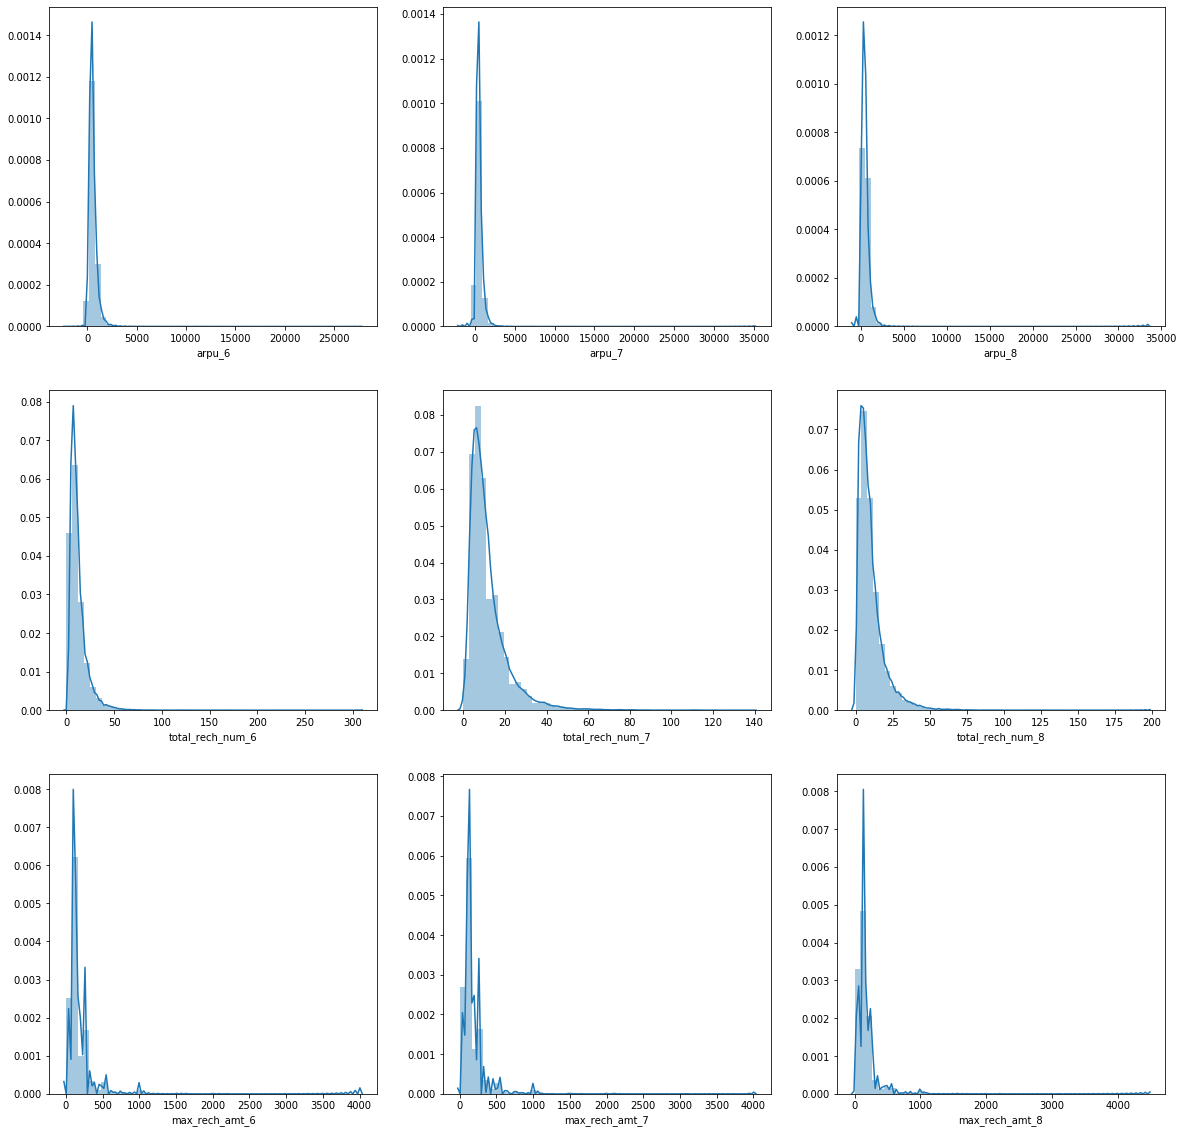

In [122]:
# Distribution plots
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.distplot(new_telecom_df['arpu_6'])
plt.subplot(3,3,2)
sns.distplot(new_telecom_df['arpu_7'])
plt.subplot(3,3,3)
sns.distplot(new_telecom_df['arpu_8'])
plt.subplot(3,3,4)
sns.distplot(new_telecom_df['total_rech_num_6'])
plt.subplot(3,3,5)
sns.distplot(new_telecom_df['total_rech_num_7'])
plt.subplot(3,3,6)
sns.distplot(new_telecom_df['total_rech_num_8'])
plt.subplot(3,3,7)
sns.distplot(new_telecom_df['max_rech_amt_6'])
plt.subplot(3,3,8)
sns.distplot(new_telecom_df['max_rech_amt_7'])
plt.subplot(3,3,9)
sns.distplot(new_telecom_df['max_rech_amt_8'])
plt.show()

Most of the columns have skewed values.

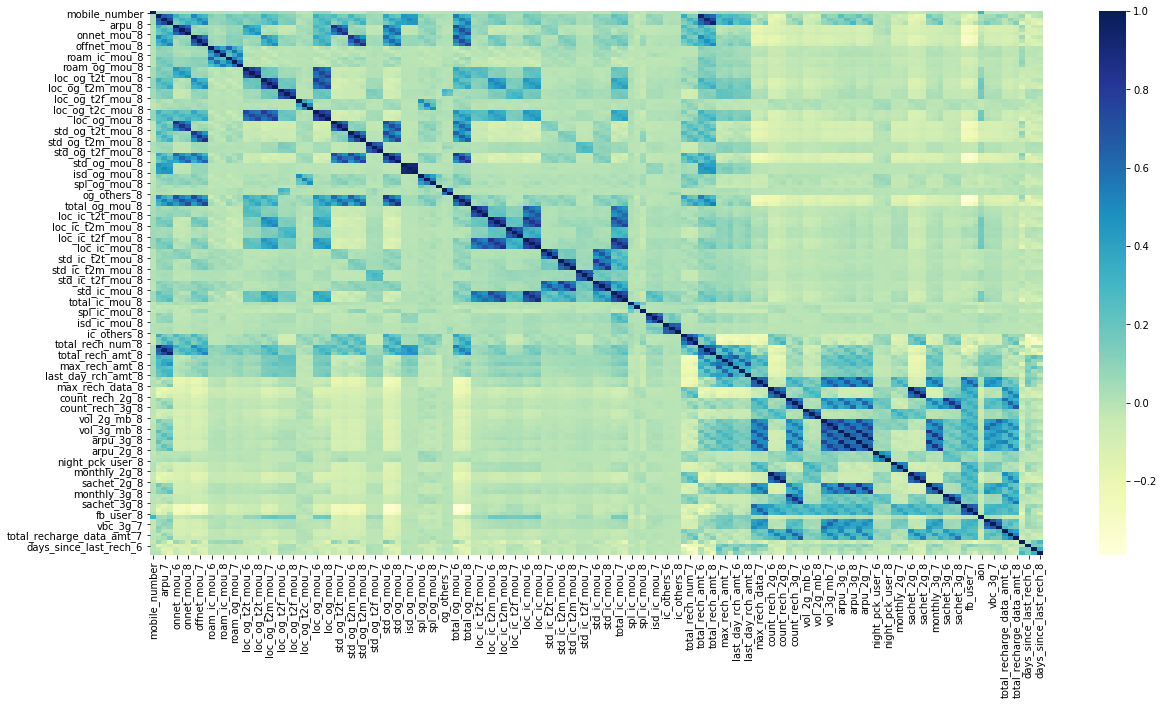

In [123]:
# Correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(new_telecom_df.corr(),cmap='YlGnBu')
plt.show()

Few Blocks of High correlation can be seen, but these may correspond to correlation between same variable of different months.
For example correlation between vol_2g_mb_6 and vol_2g_mb_7

<Figure size 1440x1080 with 0 Axes>

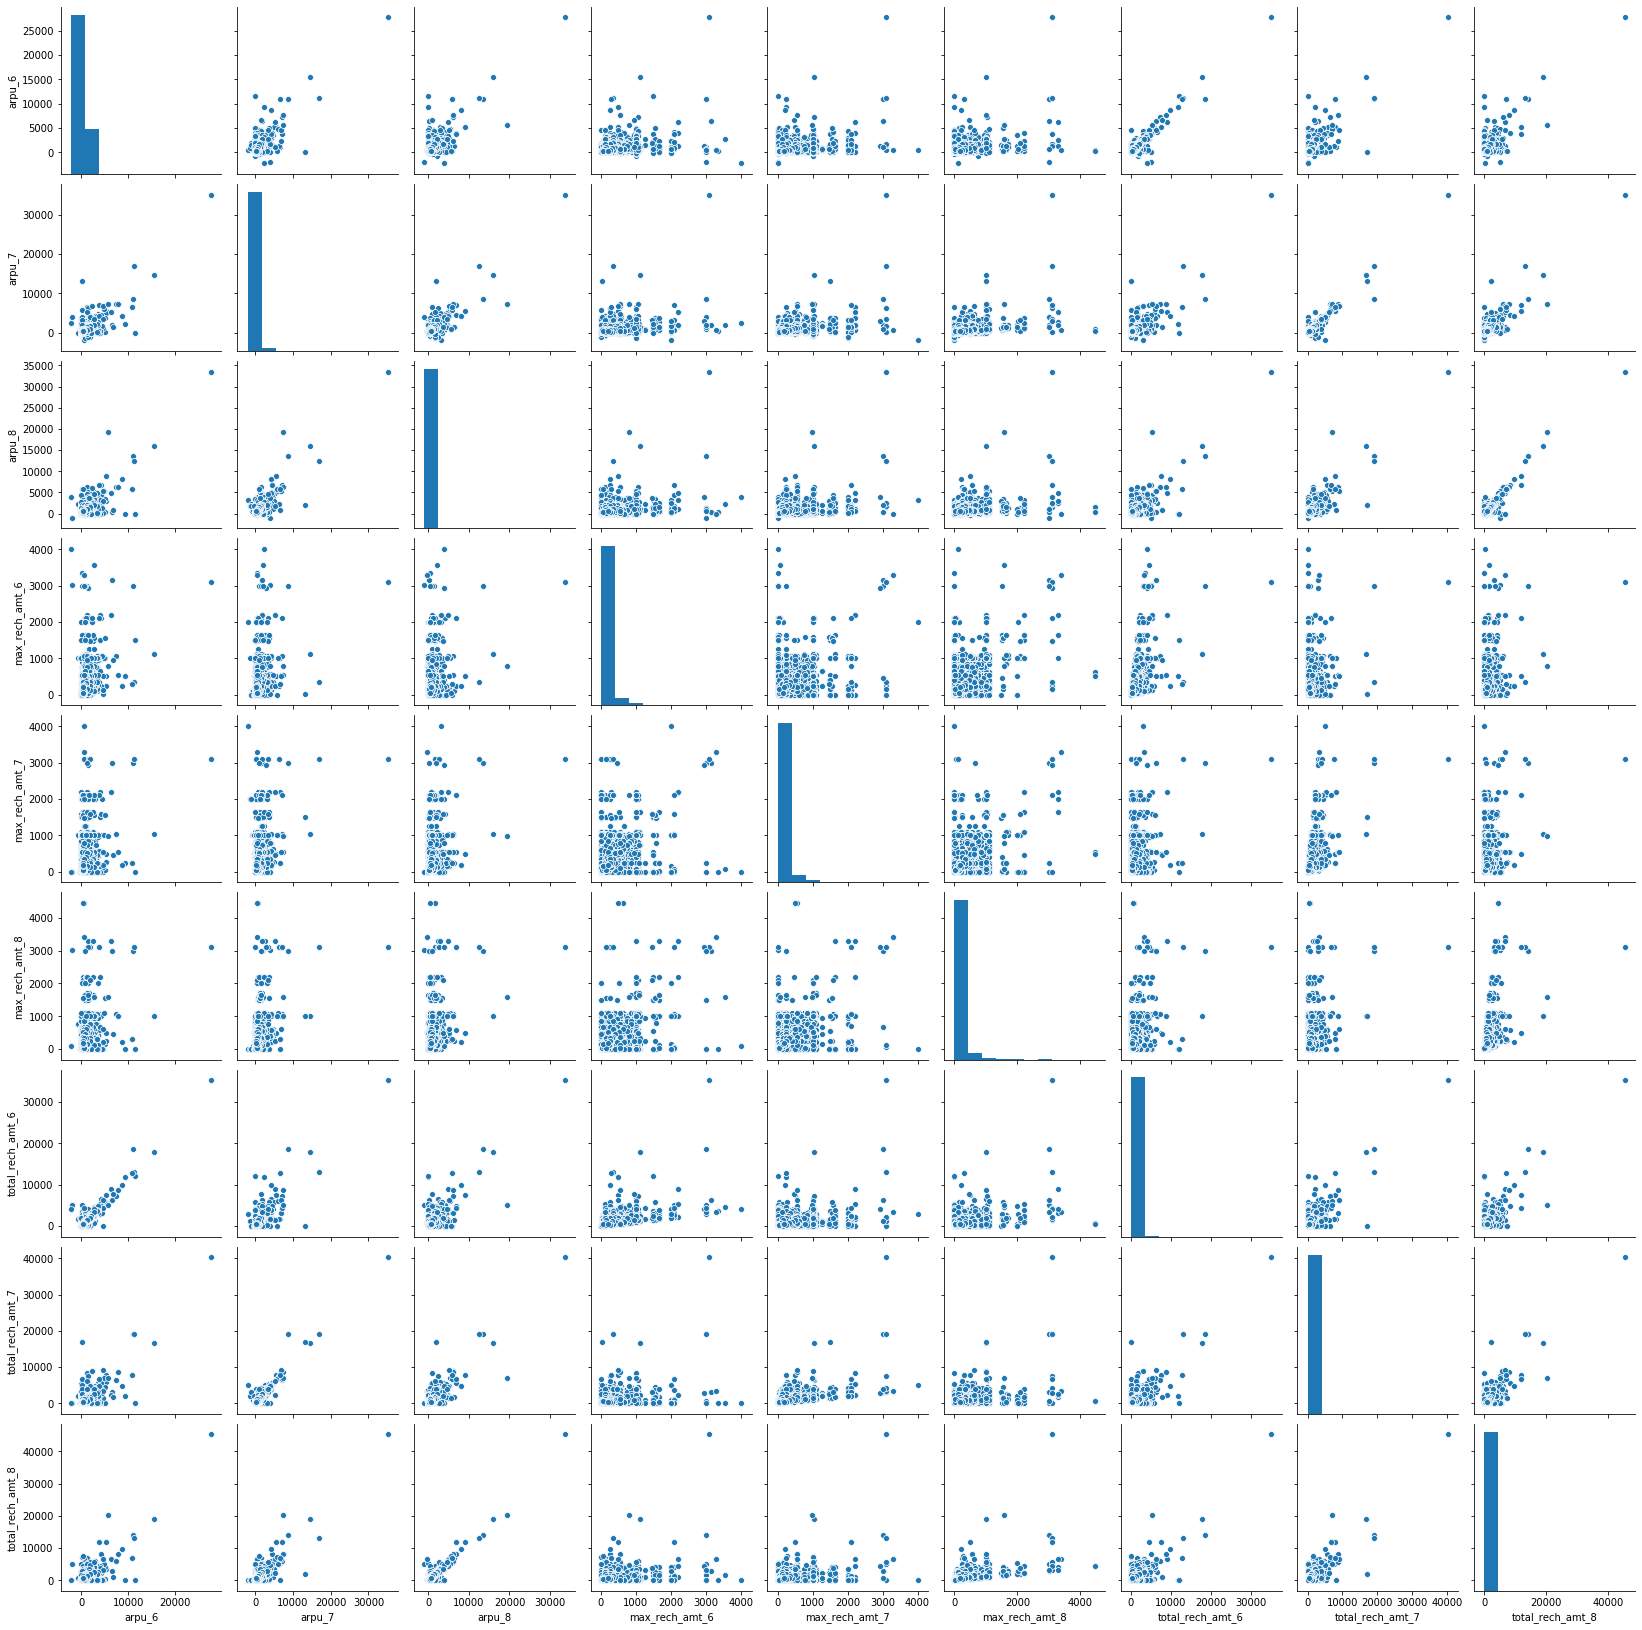

In [124]:
#Scatter Plots
plt.figure(figsize=(20,15))
sns.pairplot(new_telecom_df[['arpu_6','arpu_7','arpu_8','max_rech_amt_6','max_rech_amt_7','max_rech_amt_8',
                            'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']])
plt.show()

## One-hot encoding

In [125]:
# one_hot_encoded = pd.get_dummies(new_telecom_df[['days_since_last_rech_bucket_6','days_since_last_rech_bucket_7',
#                                                 'days_since_last_rech_bucket_8']])
# one_hot_encoded.head()

In [126]:
# one_hot_encoded.drop(['days_since_last_rech_bucket_6_Nan','days_since_last_rech_bucket_7_Nan','days_since_last_rech_bucket_8_Nan'],inplace=True,axis=1)

In [127]:
# new_telecom_df = pd.concat([new_telecom_df,one_hot_encoded],axis=1)
# new_telecom_df.drop(['days_since_last_rech_bucket_6','days_since_last_rech_bucket_7',
#                      'days_since_last_rech_bucket_8'],inplace=True,axis=1)

In [128]:
new_telecom_df.shape

(30001, 153)

## Generating and Reducing Features

In [129]:
#Since month 6 and 7 both are part of 'Good' phase, we can consider there average and reduce features
cols = new_telecom_df.filter(regex='_6|_7').columns.str[:-2]
cols.unique()

for col in cols.unique():
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    new_telecom_df[avg_col_name] = (new_telecom_df[col_6]  + new_telecom_df[col_7])/ 2

In [130]:
print ("Shape before taking average: ",new_telecom_df.shape)

cols = new_telecom_df.filter(regex='_6|_7').columns

new_telecom_df.drop(cols, axis=1, inplace=True)
print("Shape After taking average and dropping indiviual month columns: ",new_telecom_df.shape)

Shape before taking average:  (30001, 203)
Shape After taking average and dropping indiviual month columns:  (30001, 103)


Text(0.5, 1.0, 'Churn Distribution')

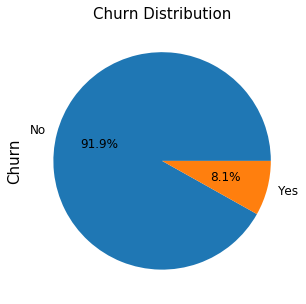

In [131]:
#Chrun Distribution Pie Chart
ax = (new_telecom_df['churn'].value_counts()*100.0 /new_telecom_df.shape[0]).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           

ax.set_ylabel('Churn',fontsize = 15)
ax.set_title('Churn Distribution', fontsize = 15)

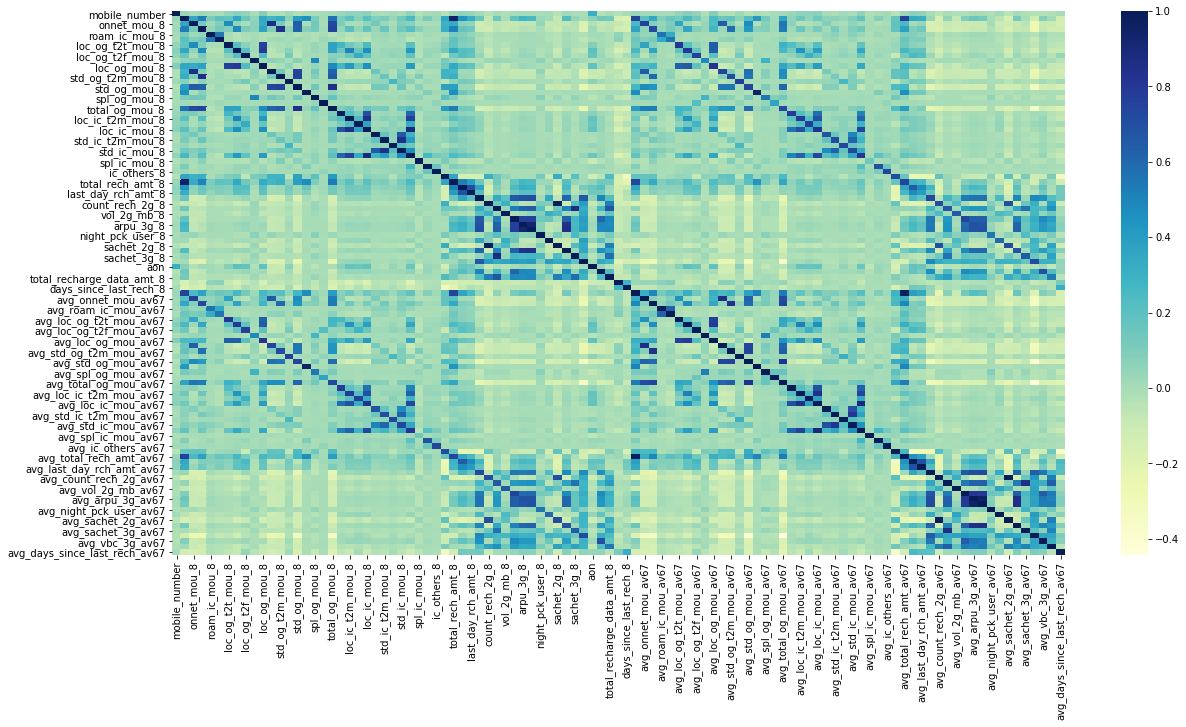

In [132]:
#Correlation matrix after reduced number of variables
plt.figure(figsize=(20,10))
sns.heatmap(new_telecom_df.corr(),cmap='YlGnBu')
plt.show()

In [133]:
#We can bucket Age on network values from days to Months and Years for more meaninful insights.
new_telecom_df['aon_mon'] = new_telecom_df['aon']/30
new_telecom_df.drop('aon', axis=1, inplace=True)
new_telecom_df['aon_mon'].head()

0     32.266667
7     26.733333
8     10.500000
21    24.000000
23    20.133333
Name: aon_mon, dtype: float64

In [134]:
#Bucketing aon_mon column
tenure = [0, 6, 12, 24, 60, 61]
tenure_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
new_telecom_df['tenure_range'] = pd.cut(new_telecom_df['aon_mon'], tenure, labels=tenure_label)
new_telecom_df['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

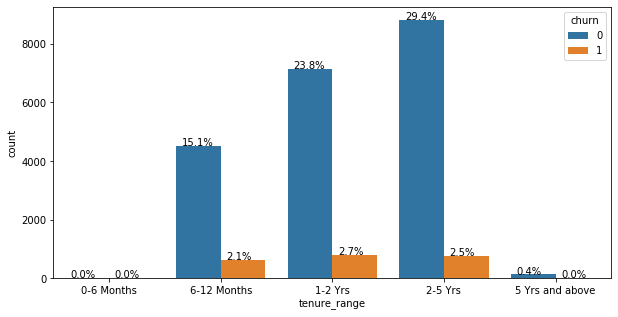

In [135]:
#Bi-variate Analysis between Tenure vs Churn
plt.figure(figsize=(10,5))
total = new_telecom_df.shape[0]
ax = sns.countplot(x="tenure_range", data=new_telecom_df, hue = "churn");
for p in ax.patches:
    ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(new_telecom_df.shape[0])), (p.get_x()+0.05, p.get_height()+20))

Although Churn percentage are almost same for 6months-5years tenure, but it can be said that <b>people with high Age on Network are less likely to Churn.</b>

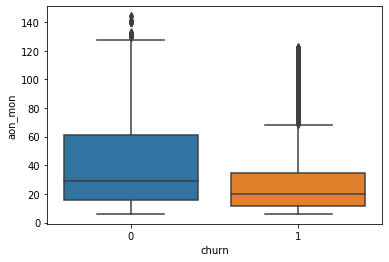

In [136]:
# Same conclusion from below box plot as well
sns.boxplot(x = new_telecom_df.churn, y = new_telecom_df.aon_mon)
plt.show()

Text(0.5, 1.0, 'Distribution of days since last recharge by churn')

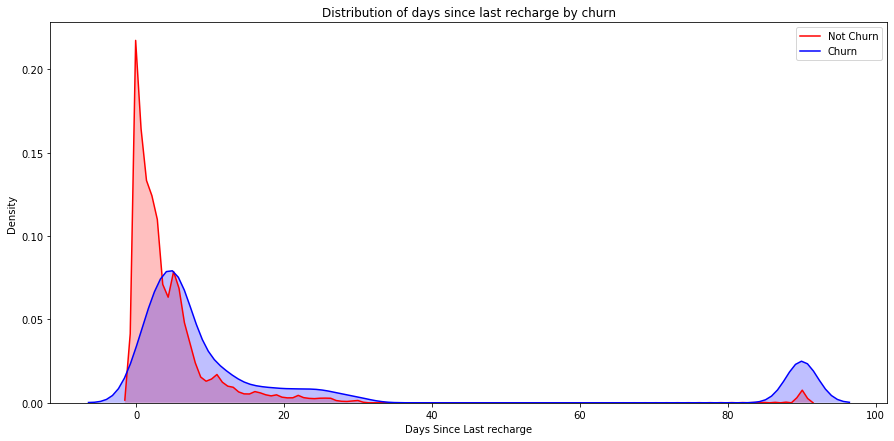

In [137]:
# Churn vs total_rech_num
plt.figure(figsize=(15,7))
ax = sns.kdeplot(new_telecom_df.days_since_last_rech_8[(new_telecom_df["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(new_telecom_df.days_since_last_rech_8[(new_telecom_df["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='best')
ax.set_ylabel('Density')
ax.set_xlabel('Days Since Last recharge')
ax.set_title('Distribution of days since last recharge by churn')

So people who have recently recharged have less probability of chrun

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

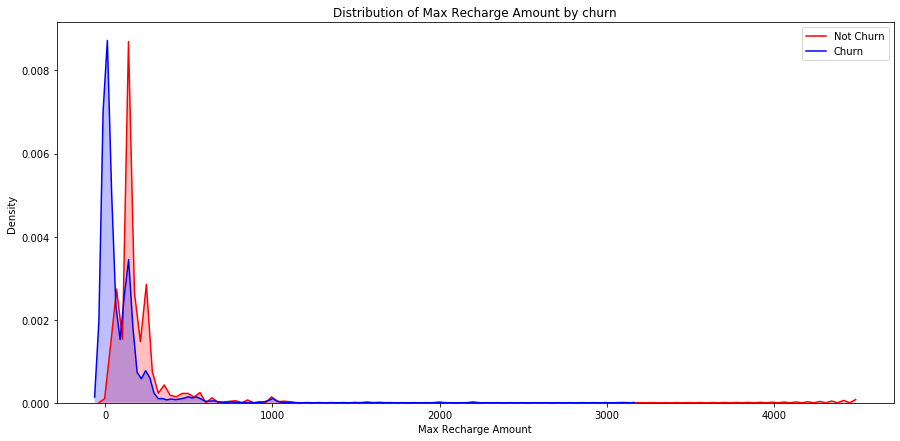

In [138]:
# Churn vs max_rech_amt
plt.figure(figsize=(15,7))
ax = sns.kdeplot(new_telecom_df.max_rech_amt_8[(new_telecom_df["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(new_telecom_df.max_rech_amt_8[(new_telecom_df["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='best')
ax.set_ylabel('Density')
ax.set_xlabel('Max Recharge Amount')
ax.set_title('Distribution of Max Recharge Amount by churn')

Clearly, people who recharge with small amount are more likely to Churn

# Model Building

In [139]:
#Dropping mobile_number and tenure_month. Tenure_month was created only to see aon_month distribution EDA
new_telecom_df.drop(['mobile_number','tenure_range'],axis=1,inplace=True)

In [140]:
y = new_telecom_df.pop('churn')
X = new_telecom_df

In [141]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sca = scaler.fit_transform(X)
X_sca = pd.DataFrame(X_sca)
X_sca.columns = X.columns

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sca, y, test_size=0.3, train_size=0.7, random_state=1)

In [143]:
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

X_train Shape :  (21000, 101)
X_test Shape :  (9001, 101)


### Handling Data Imbalance using SMOTE

In [144]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
print("Train Data imbalance before SMOTE = ", (y_train!=0).sum()/(y_train==0).sum())
X_train,y_train = sm.fit_sample(X_train,y_train)
print("Train Data imbalance after SMOTE = ", (y_train!=0).sum()/(y_train==0).sum())

Train Data imbalance before SMOTE =  0.08875985068436333
Train Data imbalance after SMOTE =  1.0


### Applying PCA

In [145]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_train)

PCA(random_state=42)

In [146]:
#Looking at the explained variance ratio for each component
pca.explained_variance_ratio_

array([1.12535875e-01, 1.05490427e-01, 6.45798389e-02, 5.87018195e-02,
       5.08551372e-02, 3.73214506e-02, 3.59100060e-02, 3.43672302e-02,
       2.79186304e-02, 2.29930362e-02, 2.08309621e-02, 2.02117057e-02,
       1.90455671e-02, 1.77422057e-02, 1.68764121e-02, 1.60723231e-02,
       1.56990751e-02, 1.50710161e-02, 1.46233540e-02, 1.39761822e-02,
       1.30660765e-02, 1.25160842e-02, 1.20892231e-02, 1.14698272e-02,
       1.13398224e-02, 1.09443044e-02, 1.00709585e-02, 9.72352743e-03,
       9.24235915e-03, 8.59567705e-03, 8.29938482e-03, 7.97494394e-03,
       7.80643207e-03, 7.64254796e-03, 7.37190543e-03, 7.26838649e-03,
       6.95630279e-03, 6.73861707e-03, 6.38384216e-03, 6.22154434e-03,
       6.04304558e-03, 5.99402272e-03, 5.75303300e-03, 5.56986222e-03,
       5.38147746e-03, 4.39112395e-03, 3.77043722e-03, 3.72670510e-03,
       3.66402955e-03, 3.29136637e-03, 3.03242214e-03, 3.01472382e-03,
       2.75400527e-03, 2.65819398e-03, 2.59801182e-03, 2.48574537e-03,
      

In [147]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

Making a screen plot for explained variance

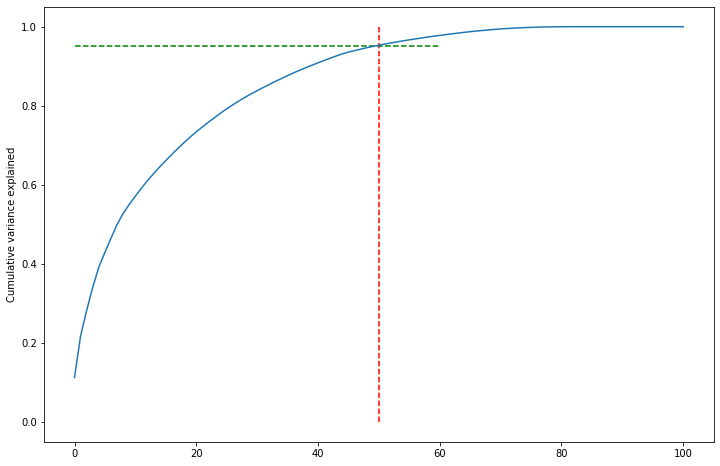

In [148]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=50, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=60, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

95% variance is explained by top 50 columns

In [149]:
#Perform PCA with 48 components. Using Incremental PCA since dataset is too large.
from sklearn.decomposition import IncrementalPCA
pca_50 = IncrementalPCA(n_components=50)
X_train_pca = pca_50.fit_transform(X_train)
X_test_pca = pca_50.transform(X_test)

### Logistic Regression with PCA

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)

LogisticRegression()

In [151]:
#Confusion matrix of train data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_train_pred = lr_pca.predict(X_train_pca)
y_test_pred = lr_pca.predict(X_test_pca)

In [152]:
cm = confusion_matrix(y_train,y_train_pred)
TP = cm[1][1]
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]
precision_train = TP/(TP+FP)
recall_train = TP/(TP+FN)
specificity_train = TN/(TN+FP)
accuracy_train = accuracy_score(y_train,y_train_pred)

In [153]:
cm = confusion_matrix(y_test,y_test_pred)
TP = cm[1][1]
FP = cm[0][1]
TN = cm[0][0]
FN = cm[1][0]
precision_test = TP/(TP+FP)
recall_test = TP/(TP+FN)
specificity_test = TN/(TN+FP)
accuracy_test = accuracy_score(y_test,y_test_pred)
#Printing test confusion matrix
cm

array([[6875, 1397],
       [ 129,  600]], dtype=int64)

In [154]:
results = pd.DataFrame({'Model':'Logistic Regression with PCA','Accuracy Train':[accuracy_train], 'Accuracy Test':[accuracy_test],
                        'Precision Train':[precision_train],
                        'Precision Test':[precision_test],'Recall Train':[recall_train], 'Recall Test':[recall_test],
                        'Specificity Train':[specificity_train], 'Specificity Test':[specificity_test]})
results

,Model,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,Specificity Train,Specificity Test
0,Logistic Regression with PCA,0.849414,0.830463,0.840362,0.300451,0.862713,0.823045,0.836116,0.831117


Since It is important to identify churners than non-churners, we would evalute models taking <b>Recall</b> as our primary evalutaion metrics

As Recall value is high on test, Logistic Regression with PCA performs very well.

In [155]:
import xgboost as xgb

xgclf = xgb.XGBClassifier()

xgclf.fit(X_train_pca, y_train)

[17:22:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [162]:
X_train_sm = pd.DataFrame(X_train_pca).sample(frac= 0.25)
X_train_sm

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
25974,1.978953,-1.270501,-1.348423,2.544386,-2.330117,0.671853,-0.418664,1.362111,-1.424137,-0.696588,...,-0.005021,0.273397,-0.371102,0.249465,0.360862,0.051723,-0.010252,-0.055405,0.205297,-0.100956
27271,6.096453,1.139776,-1.693627,-1.542782,1.765885,-1.631328,3.135744,-1.986085,-0.814426,-1.318304,...,0.131428,-0.078871,-0.258998,-0.326260,-0.198962,0.035061,0.001904,-0.070696,0.095949,-0.313370
36481,0.326840,-2.386544,0.282374,0.040950,0.086926,-0.707532,-0.210464,-0.262823,-1.573467,0.413748,...,0.161276,0.318015,-0.006163,0.090467,0.233553,0.081989,-0.035683,-0.033165,0.252424,-0.175584
25401,0.719726,-1.519580,-0.210726,-0.063996,0.232066,0.174688,-1.827786,0.295793,-0.276965,-0.104217,...,0.517398,0.309451,0.346105,0.768317,1.239467,0.498599,0.586388,-0.453798,-0.550928,-0.317213
26703,1.657937,-2.190339,-0.553231,0.335990,1.188364,-0.620067,0.680254,-0.837136,-1.390424,-0.307604,...,0.056186,0.017524,0.109592,-0.029771,0.132954,0.041581,0.031109,0.050870,-0.035260,0.057130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25311,-0.119057,-0.842514,1.323125,0.993780,-1.108296,-0.470517,0.207455,0.482825,-0.153964,0.010554,...,0.183587,-0.219943,-0.317314,0.056930,-0.453421,-0.215334,-0.194455,0.191637,0.081283,-0.206808
17448,0.740468,0.027869,-1.559530,-1.089632,0.023021,-0.306402,-1.714963,-0.589455,1.342258,-0.634372,...,-0.135170,-0.653362,-0.453021,0.514396,-1.341814,-0.705205,-0.507474,0.545924,0.770386,0.797540
2186,-1.938041,4.223724,1.165937,0.284961,0.400395,-1.480877,-1.801995,-0.467106,1.789746,-2.041188,...,-0.690312,0.229021,0.393958,-0.782304,-0.291508,0.008993,-0.268109,0.142272,-0.199071,-0.116933
22567,0.017886,-1.915175,0.820025,-0.661444,-0.297694,-0.138287,0.177648,0.430367,-1.191101,-0.075915,...,0.370008,0.377904,-0.414832,-0.272573,0.131972,0.303777,0.178149,-0.073078,0.023891,0.310303


In [163]:
from sklearn import model_selection
xgb_model = xgb.XGBClassifier(verbosity=1)
# Run for best hyperparameters
parameters = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

clf_xgb = model_selection.GridSearchCV(estimator=xgb_model,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=5,
                                       scoring=scorer,
                                       refit=True)

clf_xgb.fit(X_train_sm, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [9644, 38576]